**Kết quả ở đây chỉ là chạy thử, kết quả thật thu được khi train trên server**

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [ ]:
import tensorflow
print (tensorflow.__version__)

2.7.0


#Import Dataset: Fashion MNIST

In [ ]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

for k in range(9):
    plt.figure(figsize=(9, 6))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

#Resize Dataset

In [ ]:
trainX = [image/255 for image in trainX]
testX = [image/255 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


#GAN#

##Generator

In [ ]:
random_input = tensorflow.keras.layers.Input(shape = 100)

x = tensorflow.keras.layers.Dense(256, activation='relu')(random_input)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.Dense(512, activation='relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.Dense(1024, activation='relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.Dense(28*28)(x)
x = tensorflow.keras.layers.Reshape((28, 28, 1))(x)

generated_image = tensorflow.keras.layers.Activation('sigmoid')(x)

generator_network = tensorflow.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1024)              525312

##Discriminator

In [ ]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Flatten()(image_input)
x = tensorflow.keras.layers.Dense(1024, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.5)(x)
x = tensorflow.keras.layers.Dense(512, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.5)(x)
x = tensorflow.keras.layers.Dense(256, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.5)(x)
x = tensorflow.keras.layers.Dense(128, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.5)(x)
x = tensorflow.keras.layers.Dense(1)(x)

real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=real_vs_fake_output)
discriminator_network.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               1313

##Compiling Model

In [ ]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

In [ ]:
discriminator_network.trainable=False

g_output = generator_network(random_input)
d_output = discriminator_network(g_output)

gan_model = tensorflow.keras.models.Model(random_input, d_output)
gan_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 model (Functional)          (None, 28, 28, 1)         1493520   
                                                                 
 model_1 (Functional)        (None, 1)                 1492993   
                                                                 
Total params: 2,986,513
Trainable params: 1,489,936
Non-trainable params: 1,496,577
_________________________________________________________________


In [ ]:
gan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

##Define Data Generator

In [ ]:
# Indices of Zero Images
indices = [i for i in range(len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batch = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batch

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batch = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batch)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(9):
        plt.figure(figsize=(7, 7))
        fake_samples = get_fake_samples(generator_network, 9, noise_size)
        for j in range(9):
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[j,:,:,-1], cmap='gray_r')
            plt.axis('off')
            #plt.title(trainY[i])
        plt.show()
    return

##Train Model

In [ ]:
epochs = 20
batch_size = 100
steps = 500
noise_size = 100

losses_d = []
losses_g = []

for i in range(0, epochs):
    if (i%10 == 0):
        show_generator_results(generator_network)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_batch = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_batch, output_labels)
        
        gan_input = get_random_noise(batch_size, noise_size)
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        gan_output = np.ones((batch_size))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = gan_model.train_on_batch(gan_input, gan_output)

        losses_d.append(loss_d[0])
        losses_g.append(loss_g)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))

##Result

In [ ]:
#Generating Unlimited samples
for i in range(5):
    show_generator_results(generator_network)

##Loss Function

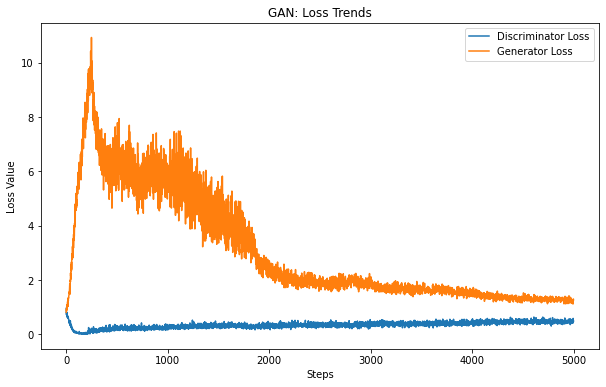

In [ ]:
steps = [i for i in range(len(losses_d))]
plt.figure(figsize=(10, 6))
plt.plot(losses_d[:5000])
plt.plot(losses_g[:5000])
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("GAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()

In [ ]:
generator_network.save('/content/drive/MyDrive/CS115/Notebooks/FashionMNIST_GAN')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CS115/Notebooks/FashionMNIST_GAN/assets


#DCGAN#

##Generator

In [ ]:
random_input = tensorflow.keras.layers.Input(shape = 100)

x = tensorflow.keras.layers.Dense(128 * 5 * 5)(random_input)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Reshape((5, 5, 128))(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(8,8))(x)
generated_image = tensorflow.keras.layers.Activation('sigmoid')(x)

generator_network = tensorflow.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 3200)              323200    
                                                                 
 activation (Activation)     (None, 3200)              0         
                                                                 
 batch_normalization (BatchN  (None, 3200)             12800     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 5, 5, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 9, 9, 128)        409728    
 nspose)                                                     

##Discriminator

In [ ]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3))(image_input)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=2)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Flatten()(x)

x = tensorflow.keras.layers.Dense(1)(x)
real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=real_vs_fake_output)
discriminator_network.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 26, 26, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 11, 11, 128)       0         
                                                                 
 batch_normalization_3 (Batc  (None, 11, 11, 128)      512       
 hNormalization)                                                 
                                                           

##Compiling Model

In [ ]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

In [ ]:
discriminator_network.trainable=False

g_output = generator_network(random_input)
d_output = discriminator_network(g_output)

dcgan_model = tensorflow.keras.models.Model(random_input, d_output)
dcgan_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 model (Functional)          (None, 28, 28, 1)         2360833   
                                                                 
 model_1 (Functional)        (None, 1)                 1223553   
                                                                 
Total params: 3,584,386
Trainable params: 2,353,921
Non-trainable params: 1,230,465
_________________________________________________________________


In [ ]:
dcgan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

##Define Generator Data

In [ ]:
indices = [i for i in range(0, len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batch = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batch

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batch = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batch)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(9):
        plt.figure(figsize=(7, 7))
        fake_samples = get_fake_samples(generator_network, 9, noise_size)
        for j in range(9):
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[j,:,:,-1], cmap='gray_r')
            plt.axis('off')
            #plt.title(trainY[i])
        plt.show()
    return

##Train Model

In [ ]:
epochs = 100
batch_size = 100
steps = 500
noise_size = 100

losses_d = []
losses_g = []

for i in range(0, epochs):
    if (i%10 == 0):
        show_generator_results(generator_network)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_batch = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_batch, output_labels)
        
        gan_input = get_random_noise(batch_size, noise_size)
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        gan_output = np.ones((batch_size))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = dcgan_model.train_on_batch(gan_input, gan_output)

        losses_d.append(loss_d[0])
        losses_g.append(loss_g)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))

##Results

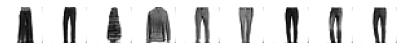

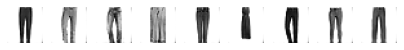

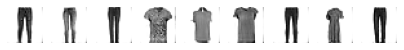

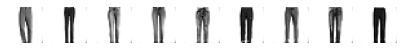

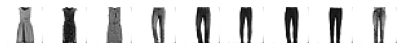

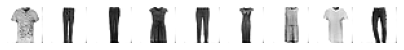

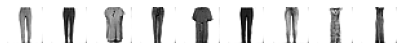

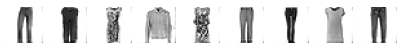

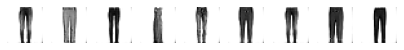

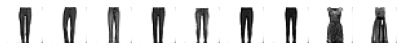

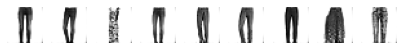

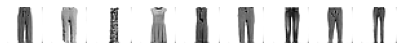

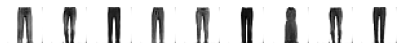

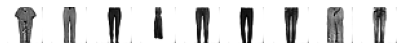

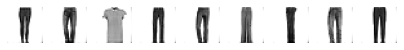

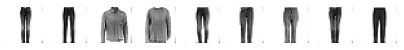

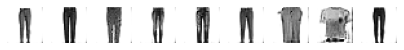

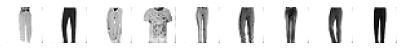

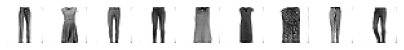

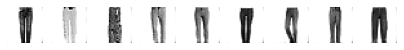

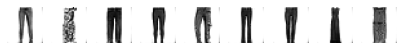

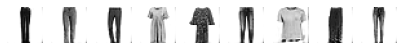

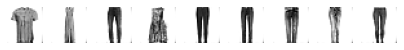

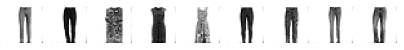

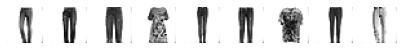

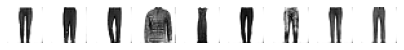

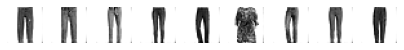

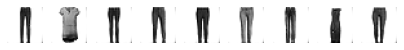

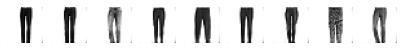

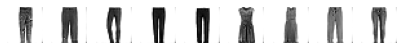

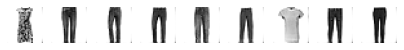

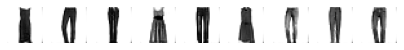

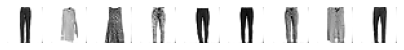

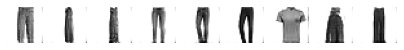

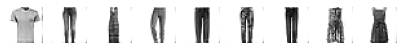

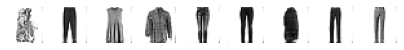

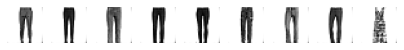

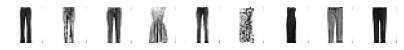

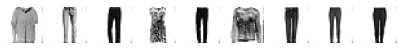

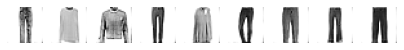

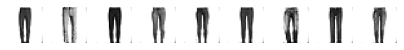

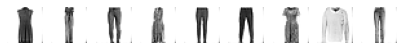

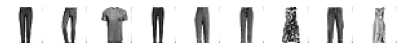

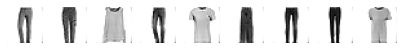

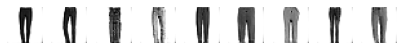

In [ ]:
#Generating Unlimited samples
for i in range(5):
    show_generator_results(generator_network)

In [ ]:
generator_network.save('/content/drive/MyDrive/DCGAN_Fashion')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DCGAN_Fashion/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DCGAN_Fashion/assets


#Loss Function

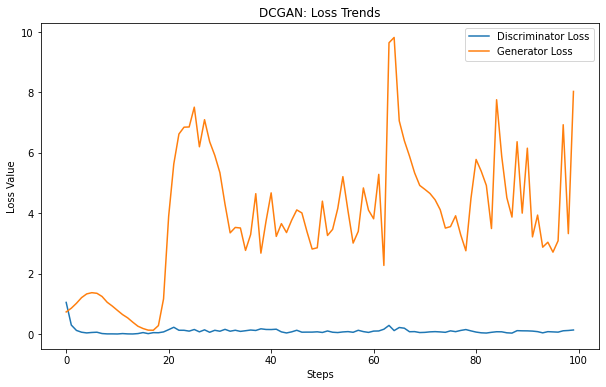

In [ ]:
steps = [i for i in range(len(losses_d))]
plt.figure(figsize=(10, 6))
plt.plot(losses_d[:100])
plt.plot(losses_g[:100])
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("DCGAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()

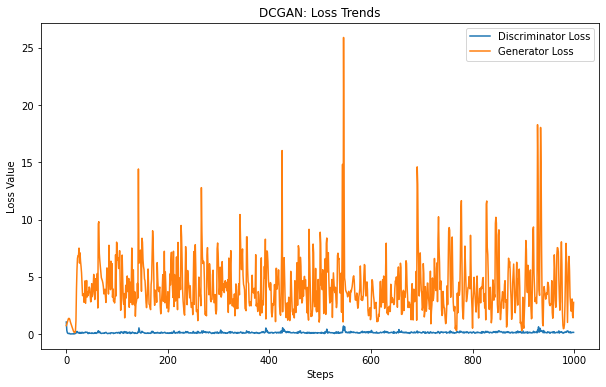

In [ ]:
steps = [i for i in range(len(losses_d))]
plt.figure(figsize=(10, 6))
plt.plot(losses_d[:1000])
plt.plot(losses_g[:1000])
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("DCGAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()

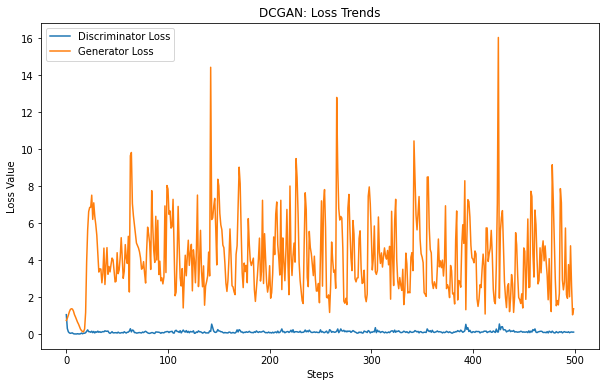

In [ ]:
steps = [i for i in range(len(losses_d))]
plt.figure(figsize=(10, 6))
plt.plot(losses_d[:500])
plt.plot(losses_g[:500])
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("DCGAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()

In [ ]:
loss_d = []
loss_g = []
for i in range(len(losses_d)):
  if i%500==0:
    loss_g.append(losses_g[i-1])
    loss_d.append(losses_d[i-1])

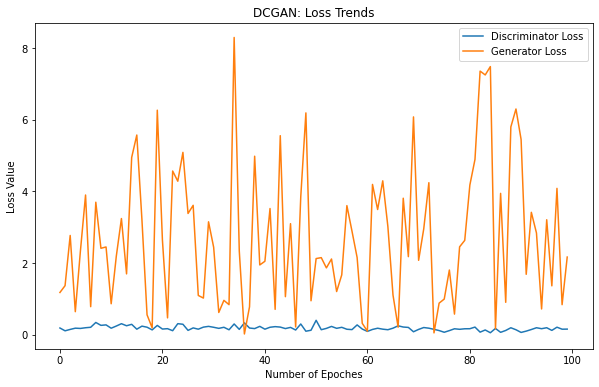

In [ ]:
steps = [i for i in range(len(losses_d))]
plt.figure(figsize=(10, 6))
plt.plot(loss_d)
plt.plot(loss_g)
plt.xlabel('Number of Epoches')
plt.ylabel('Loss Value')
plt.title("DCGAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()

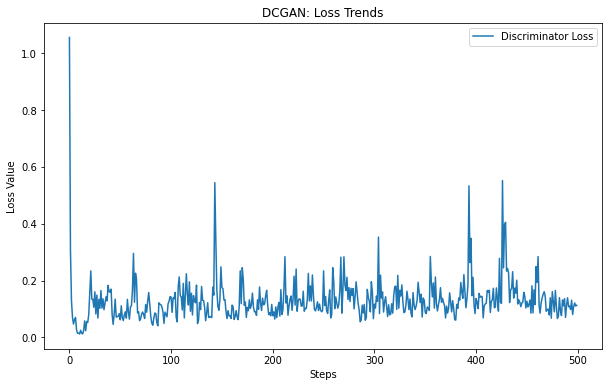

In [ ]:
steps = [i for i in range(len(losses_d))]
plt.figure(figsize=(10, 6))
plt.plot(losses_d[:500])
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("DCGAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()